# New sequence data generator

Depending on the batch size, the sequence data generator returns specified number of slices from each patient.

In [341]:
import tensorflow as tf
import keras
from keras.callbacks import Callback
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard

import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt
import importlib

import time

In [342]:
import datagen
import model

In [343]:
# Reload lib contents
importlib.reload(datagen)
importlib.reload(model)

<module 'model' from 'C:\\Users\\krcma\\Desktop\\tf_segmentation\\unet_segmentation\\model.py'>

##  Hyperparemeters

In [344]:
train_HGG_patients = 239
valid_HGG_patients = 20
slices_from_patient = 15
image_size = 240
channels = 4
# learning_rate = 0.0001
learning_rate = 5e-1
epochs = 25
batch_size = 10

## Dataset loading

In [345]:
x_train, y_train = datagen.get_dataset(slices_from_patient, 
                file_path='../dataset/', 
                mode='training', 
                glioma_type=['HGG'], 
                tumor_region=-1, 
                slices_w_tumor_only=False,
                slices_w_less_brain=None,
                image_size=image_size,
                train_HGG_patients=train_HGG_patients)

training data with shape: (3585, 4, 240, 240) (3585, 1, 240, 240)


In [346]:
x_valid, y_valid = datagen.get_dataset(slices_from_patient, 
                file_path='../dataset/', 
                mode='validation', 
                glioma_type=['HGG'], 
                tumor_region=-1, 
                slices_w_tumor_only=False,
                slices_w_less_brain=None,
                image_size=240,
                train_HGG_patients=valid_HGG_patients)

validation data with shape: (300, 4, 240, 240) (300, 1, 240, 240)


## U-Net

In [347]:
model = model.UNet(channels, image_size)
adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, 
                                       beta_1=0.9, 
                                       beta_2=0.999)
sgd_optimizer = keras.optimizers.SGD(learning_rate=learning_rate, 
                                     momentum=0.5, 
                                     nesterov=True)
model.compile(optimizer=adam_optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )

Compiled with input shape (None, 4, 240, 240)


## Slice  augmentation

In [358]:
data_gen_args = dict(data_format="channels_first",
#                      fill_mode="constant",
#                      cval=0,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     rotation_range=20,
                     horizontal_flip=True,
                     vertical_flip=True)
seed = 2048

In [359]:
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [360]:
image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

In [361]:
x_train_datagen = image_datagen.flow(x_train, batch_size=batch_size, seed=seed)
y_train_datagen = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

In [362]:
datagen = zip(x_train_datagen, y_train_datagen)

In [363]:
for i, v in enumerate(datagen):
    if i == 1: break
    print(v[0].shape)

(10, 4, 240, 240)


In [364]:
i = random.randint(0,238)

In [365]:
print("Values testing ")
print(y_train[i][0].shape)
print(np.unique(y_train[i][0]))

Values testing 
(240, 240)
[0.]


In [366]:
im = y_train_datagen.__getitem__(i)[0][0]
print("Values testing after data augmentation")
print(im.shape)
print("number of unique values", len(np.unique(im)))
# print(np.unique(im))

Values testing after data augmentation
(240, 240)
number of unique values 1


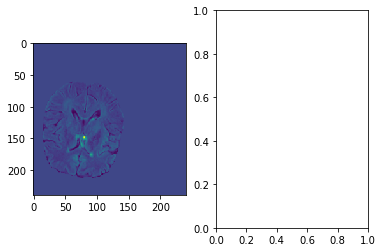

In [367]:
# i = random.randint(0,238)
map_1 = y_train_datagen.__getitem__(i)[0][0]
map_1[map_1 == 0] = np.nan
map_2 = y_train[i][0]
map_2[map_2 == 0] = np.nan

f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train_datagen.__getitem__(i)[0][0]) #, cmap='gray', vmin=0
axarr[0].imshow(map_1, alpha=0.5)
# axarr[1].imshow(x_train[i][0]) #, cmap='gray', vmin=0
# axarr[1].imshow(map_2, alpha=0.9)

## Callbacks

In [31]:
callbacks = [
    keras.callbacks.callbacks.TerminateOnNaN(),
    keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0.0001, 
                                            patience=10, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True)
    TensorBoard(log_dir="logs/{}".format(time()))
]

# Training

In [33]:
train_steps = train_HGG_patients * slice_per_patient
valid_steps = valid_HGG_patients * slice_per_patient

# hist = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
#                     epochs=epochs, shuffle=True, callbacks=callbacks)

# hist = model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), 
#                     epochs=epochs, callbacks=callbacks, batch_size=batch_size)

hist = model.fit_generator(datagen, validation_data=(x_valid, y_valid), steps_per_epoch=train_steps,
                    epochs=epochs, callbacks=callbacks)

# model.save("../models/2020040100.h5")

Epoch 1/25
239/239 [==============================] - 151s 633ms/step - loss: 56.7678 - accuracy: 0.0237 - val_loss: 81.1330 - val_accuracy: 0.0240
Epoch 2/25
239/239 [==============================] - 150s 627ms/step - loss: 54.1522 - accuracy: 0.0267 - val_loss: 77.6502 - val_accuracy: 0.0179
Epoch 3/25
239/239 [==============================] - 148s 619ms/step - loss: 53.5299 - accuracy: 0.0322 - val_loss: 80.0883 - val_accuracy: 0.0286
Epoch 4/25
239/239 [==============================] - 148s 619ms/step - loss: 53.9716 - accuracy: 0.0213 - val_loss: 77.7981 - val_accuracy: 0.0309
Epoch 5/25
239/239 [==============================] - 149s 621ms/step - loss: 51.6187 - accuracy: 0.0198 - val_loss: 77.4820 - val_accuracy: 0.0096
Epoch 6/25
239/239 [==============================] - 148s 617ms/step - loss: 54.3820 - accuracy: 0.0212 - val_loss: 78.7108 - val_accuracy: 0.0154
Epoch 7/25
239/239 [==============================] - 147s 616ms/step - loss: 53.5930 - accuracy: 0.0304 - val_l

### Results

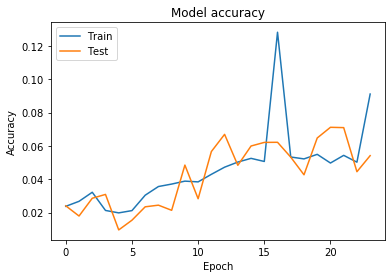

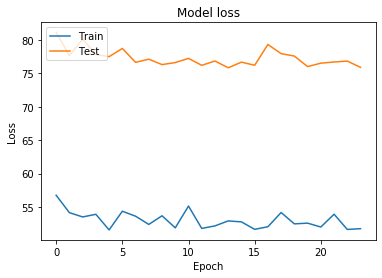

In [34]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [48]:
print(dir(datagen))
print(datagen.__iter__()[0])
print(x_valid.shape)

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


TypeError: 'zip' object is not subscriptable

NameError: name 'pred' is not defined

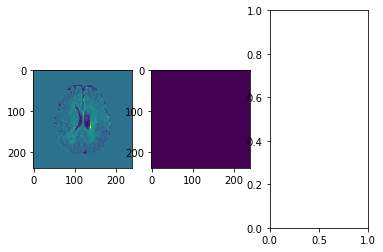

In [39]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(x_valid[0][0]) #, cmap='gray', vmin=0
axarr[1].imshow(y_valid[0][0]) #, cmap='gray', vmin=0
axarr[2].imshow(pred[0][0]) #, cmap='gray', vmin=0